In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader, Subset
from typing import Tuple, Optional, Dict
import os
import numpy as np
import torchvision.transforms as transforms
from timm.models.mobilenetv3 import mobilenetv3_large_075
from dataset import FaceVerificationDataset

In [2]:
model = mobilenetv3_large_075(pretrained=False, num_classes=64)
print(f"Paremeters: {sum(p.numel() for p in model.parameters())/1e6:.2f} M")

Paremeters: 2.79 M


In [3]:
def create_dataloaders(
    data_dir: str,
    batch_size: int = 32,
    num_workers: int = 4,
    img_size: int = 224,
    pin_memory: bool = True,
    train_transforms: Optional[object] = None,
    val_transforms: Optional[object] = None
) -> Tuple[DataLoader, DataLoader, Dict]:
    """
    創建訓練和驗證用的 DataLoader
    
    Args:
        data_dir (str): 資料根目錄
        batch_size (int): 批次大小
        num_workers (int): DataLoader 工作程序數
        img_size (int): 圖片大小
        pin_memory (bool): 是否使用 pin_memory
        train_transforms: 自定義訓練資料轉換
        val_transforms: 自定義驗證資料轉換
    
    Returns:
        train_loader: 訓練用 DataLoader
        val_loader: 驗證用 DataLoader
        dataset_sizes: 資料集大小資訊
    """
    
    # 創建訓練集
    train_dataset = FaceVerificationDataset(
        root_dir=data_dir,
        split='train',
        img_size=img_size,
        transform=train_transforms,
        normalize=True
    )
    
    # 創建驗證集
    val_dataset = FaceVerificationDataset(
        root_dir=data_dir,
        split='val',
        img_size=img_size,
        transform=val_transforms,
        normalize=True
    )
    
    # 計算每個 epoch 的步數，用於後續的學習率調整等
    steps_per_epoch = len(train_dataset) // batch_size
    
    # 創建 DataLoader
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=pin_memory,
        drop_last=True  # 捨棄最後不完整的 batch
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,  # 驗證集不需要打亂
        num_workers=num_workers,
        pin_memory=pin_memory,
        drop_last=False  # 驗證時保留所有樣本
    )
    
    # 記錄資料集資訊
    dataset_info = {
        'train_size': len(train_dataset),
        'val_size': len(val_dataset),
        'steps_per_epoch': steps_per_epoch,
        'num_classes': 2,  # binary classification
        'img_size': img_size
    }
    
    return train_loader, val_loader, dataset_info

In [4]:
def create_subset_dataloaders(
    data_dir: str,
    batch_size: int = 32,
    num_workers: int = 4,
    img_size: int = 224,
    pin_memory: bool = True,
    train_transforms: Optional[object] = None,
    val_transforms: Optional[object] = None,
    subset_size: int = 1000
) -> Tuple[DataLoader, DataLoader, Dict]:
    """
    創建訓練和驗證用的 DataLoader，僅使用部分資料集
    
    Args:
        data_dir (str): 資料根目錄
        batch_size (int): 批次大小
        num_workers (int): DataLoader 工作程序數
        img_size (int): 圖片大小
        pin_memory (bool): 是否使用 pin_memory
        train_transforms: 自定義訓練資料轉換
        val_transforms: 自定義驗證資料轉換
        subset_size (int): 子集大小
    
    Returns:
        train_loader: 訓練用 DataLoader
        val_loader: 驗證用 DataLoader
        dataset_sizes: 資料集大小資訊
    """
    
    # 創建訓練集
    train_dataset = FaceVerificationDataset(
        root_dir=data_dir,
        split='train',
        img_size=img_size,
        transform=train_transforms,
        normalize=True
    )
    
    # 創建驗證集
    val_dataset = FaceVerificationDataset(
        root_dir=data_dir,
        split='val',
        img_size=img_size,
        transform=val_transforms,
        normalize=True
    )
    
    # 隨機選取子集
    train_subset = Subset(train_dataset, np.random.choice(len(train_dataset), subset_size, replace=False))
    val_subset = Subset(val_dataset, np.random.choice(len(val_dataset), subset_size, replace=False))
    
    # 計算每個 epoch 的步數，用於後續的學習率調整等
    steps_per_epoch = len(train_subset) // batch_size
    
    # 創建 DataLoader
    train_loader = DataLoader(
        train_subset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=pin_memory,
        drop_last=True  # 捨棄最後不完整的 batch
    )
    
    val_loader = DataLoader(
        val_subset,
        batch_size=batch_size,
        shuffle=False,  # 驗證集不需要打亂
        num_workers=num_workers,
        pin_memory=pin_memory,
        drop_last=False  # 驗證時保留所有樣本
    )

    # label_count_train = [0, 0]
    # label_count_val = [0, 0]
    # train_labels = np.array([int(label) for _, _, label in train_subset])
    # val_labels = np.array([int(label) for _, _, label in val_subset])
    
    # label_count_train = np.bincount(train_labels, minlength=2).tolist()
    # label_count_val = np.bincount(val_labels, minlength=2).tolist()

    # 記錄資料集資訊
    dataset_info = {
        'train_size': len(train_subset),
        'val_size': len(val_subset),
        'steps_per_epoch': steps_per_epoch,
        'num_classes': 2,  # binary classification
        'img_size': img_size,
        # 'label_distribution': {
        #     'train' : label_count_train,
        #     'val' : label_count_val
        # }
    }

    return train_loader, val_loader, dataset_info

# 使用範例
def main(EPOCHS=20):
    # 基本參數設置
    config = {
        'data_dir': './dataset',
        'batch_size': 64,
        'num_workers': os.cpu_count(),  # 使用一半的 CPU 核心數
        'img_size': 224,
        'pin_memory': torch.cuda.is_available(),  # 如果有 GPU 就啟用
    }
    
    # 可選：自定義訓練集的資料增強
    train_transforms = transforms.Compose([
        transforms.Resize((config['img_size'], config['img_size'])),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])
    
    # 驗證集只需要基本轉換
    val_transforms = transforms.Compose([
        transforms.Resize((config['img_size'], config['img_size'])),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])
    
    # 創建 dataloaders
    # train_loader, val_loader, dataset_info = create_dataloaders(
    #     data_dir=config['data_dir'],
    #     batch_size=config['batch_size'],
    #     num_workers=config['num_workers'],
    #     img_size=config['img_size'],
    #     pin_memory=config['pin_memory'],
    #     train_transforms=train_transforms,
    #     val_transforms=val_transforms
    # )
    train_loader_subset, val_loader, dataset_info = create_subset_dataloaders(
        data_dir=config['data_dir'],
        batch_size=config['batch_size'],
        num_workers=config['num_workers'],
        img_size=config['img_size'],
        pin_memory=config['pin_memory'],
        train_transforms=train_transforms,
        val_transforms=val_transforms,
        subset_size=10000
    )

    print(f"Dataset Info:")
    print(f"Training samples: {dataset_info['train_size']}")
    print(f"Validation samples: {dataset_info['val_size']}")
    print(f"Steps per epoch: {dataset_info['steps_per_epoch']}")
    # print(f"Training label distribution: 1: {dataset_info['label_distribution']['train'][1]}, 0: {dataset_info['label_distribution']['train'][0]}")
    # print(f"Validation label distribution: 1: {dataset_info['label_distribution']['val'][1]}, 0: {dataset_info['label_distribution']['val'][0]}")
    
    model = mobilenetv3_large_075(pretrained=False, num_classes=64)
    model = model.cuda()
    criterion_alpha = nn.CosineSimilarity()
    # criterion_beta = nn.MSELoss()
    # criterion_beta = nn.L1Loss()
    criterion_beta = nn.SmoothL1Loss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-3)
    scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-5)

    # Record training process
    loss_history = []
    acc_history = []
    val_acc_history = []

    # 使用 dataloader
    # for batch_idx, (img1, img2, labels) in enumerate(train_loader):
    test=0
    for epoch in range(EPOCHS):
        model.train()
        loss_epoch = 0
        total = 0
        cnt = 0
        tp = 0
        tn = 0

        for batch_idx, (img1, img2, labels) in enumerate(train_loader_subset):
            img1, img2, labels = img1.cuda(), img2.cuda(), labels.cuda()
            
            optimizer.zero_grad()
            output1 = model(img1)
            output2 = model(img2)
            loss = criterion_beta(criterion_alpha(output1, output2), labels)
            loss.backward()
            optimizer.step()

            loss_epoch += loss.item()
            total += labels.size(0)
            distance = F.cosine_similarity(output1, output2)
            cnt += 1
            tp += ((distance > 0.5) & (labels == 1)).sum().item()
            tn += ((distance <= 0.5) & (labels == 0)).sum().item()

            if batch_idx % 1 == 0:
                print("                 ", end="\r")
                print(f"Epoch {epoch+1}/{EPOCHS}, Step {batch_idx}/{dataset_info['steps_per_epoch']}, Loss: {loss_epoch/cnt:.4f}, Acc: {(tp+tn)/total:.4f}", end="\r")
        
        scheduler.step()
        loss_history.append(loss_epoch / cnt)
        acc_history.append((tp+tn) / total)
        
        # Validation
        model.eval()
        tp = 0
        tn = 0
        total = 0
        print(" ")
        with torch.no_grad():
            for img1, img2, labels in val_loader:
                img1, img2, labels = img1.cuda(), img2.cuda(), labels.cuda()
                output1 = model(img1)
                output2 = model(img2)
                loss = criterion_beta(criterion_alpha(output1, output2), labels)
                distance = F.cosine_similarity(output1, output2)
                tp += ((distance > 0.5) & (labels == 1)).sum().item()
                tn += ((distance <= 0.5) & (labels == 0)).sum().item()
                total += labels.size(0)

        val_acc_history.append((tp+tn) / total)

        print(f"Validation accuracy: {(tp+tn)/total:.4f}")

        

    # Save model
    torch.save(model.state_dict(), 'model.pth')

    return loss_history, acc_history, val_acc_history

In [5]:
loss_history, acc_history, val_acc_history = main(EPOCHS=20)

Dataset Info:
Training samples: 10000
Validation samples: 10000
Steps per epoch: 156
 poch 1/20, Step 155/156, Loss: 0.1523, Acc: 0.5350
Validation accuracy: 0.5386
 poch 2/20, Step 155/156, Loss: 0.1428, Acc: 0.5340
Validation accuracy: 0.5270
 poch 3/20, Step 155/156, Loss: 0.1387, Acc: 0.5400
Validation accuracy: 0.5816
 poch 4/20, Step 155/156, Loss: 0.1308, Acc: 0.5705
Validation accuracy: 0.6052
 poch 5/20, Step 155/156, Loss: 0.1238, Acc: 0.6038
Validation accuracy: 0.6232
 poch 6/20, Step 155/156, Loss: 0.1184, Acc: 0.6241
Validation accuracy: 0.6365
 poch 7/20, Step 155/156, Loss: 0.1141, Acc: 0.6409
Validation accuracy: 0.6316
 poch 8/20, Step 155/156, Loss: 0.1098, Acc: 0.6602
Validation accuracy: 0.6617
 poch 9/20, Step 155/156, Loss: 0.1059, Acc: 0.6735
Validation accuracy: 0.6540
 poch 10/20, Step 155/156, Loss: 0.1025, Acc: 0.6836
Validation accuracy: 0.6678
 poch 11/20, Step 155/156, Loss: 0.0992, Acc: 0.6937
Validation accuracy: 0.6806
 poch 12/20, Step 155/156, Loss: 

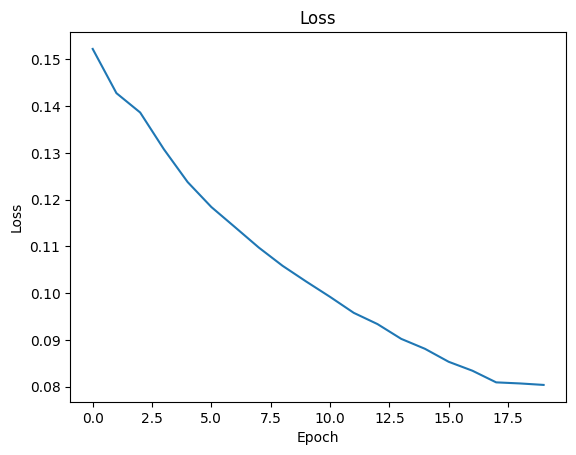

In [6]:
import matplotlib.pyplot as plt

# plot loss

plt.plot(loss_history)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [7]:
# load model
model = mobilenetv3_large_075(pretrained=False, num_classes=64)
model.load_state_dict(torch.load('model.pth'))
print(f"Model parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6:.2f} M")

Model parameters: 2.79 M


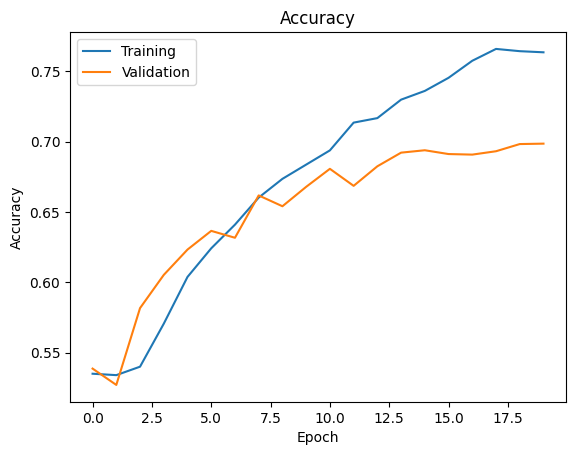

In [8]:
# plot accuracy

plt.plot(acc_history, label='Training')
plt.plot(val_acc_history, label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [9]:
# 可選：自定義訓練集的資料增強
train_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])
    
    # 驗證集只需要基本轉換
val_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])

In [24]:
# Validation
from PIL import Image
vp1_a = './dataset/val/n000001/0004_01.jpg'
vp1_b = './dataset/val/n000001/0002_01.jpg'

vp2_a = './dataset/val/n000009/0004_01.jpg'
vp2_b = './dataset/val/n000009/0005_01.jpg'

# to tensor
img1 = val_transforms(Image.open(vp1_a)).unsqueeze(0).cuda()
img2 = val_transforms(Image.open(vp1_b)).unsqueeze(0).cuda()
img3 = val_transforms(Image.open(vp2_a)).unsqueeze(0).cuda()
img4 = val_transforms(Image.open(vp2_b)).unsqueeze(0).cuda()

model.eval()
model = model.cuda()
ceriation_alpha = nn.CosineSimilarity()
output1 = model(img1)
output2 = model(img2)
output3 = model(img3)
output4 = model(img4)

alpha1 = ceriation_alpha(output1, output2) # should be close to 1
alpha2 = ceriation_alpha(output3, output4) # should be close to 1

beta1 = ceriation_alpha(output1, output3) # should be close to 0
beta2 = ceriation_alpha(output2, output4) # should be close to 0

print(f"Validation Pair 1 Similarity: {alpha1.item()}")
print(f"Validation Pair 2 Similarity: {alpha2.item()}")
print(f"Validation Pair 1 Dissimilarity: {beta1.item()}")
print(f"Validation Pair 2 Dissimilarity: {beta2.item()}")

Validation Pair 1 Similarity: 0.9587056636810303
Validation Pair 2 Similarity: 0.9011247158050537
Validation Pair 1 Dissimilarity: 0.10630252957344055
Validation Pair 2 Dissimilarity: -0.03886476159095764


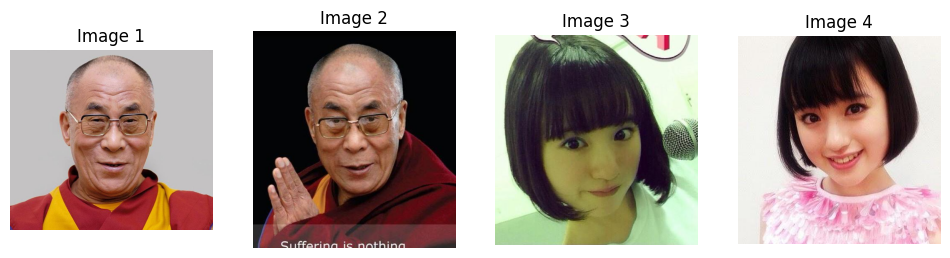

In [26]:
# plot 4 images comparison
# Validation Pair 1 Similarity: 0.9587056636810303
# Validation Pair 2 Similarity: 0.9011247158050537
# Validation Pair 1 Dissimilarity: 0.10630252957344055
# Validation Pair 2 Dissimilarity: -0.03886476159095764

import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(12, 3))
img1 = Image.open(vp1_a)
img2 = Image.open(vp1_b)
img3 = Image.open(vp2_a)
img4 = Image.open(vp2_b)
axs[0].imshow(img1)
axs[0].set_title('Image 1')
axs[0].axis('off')
axs[1].imshow(img2)
axs[1].set_title('Image 2')
axs[1].axis('off')
axs[2].imshow(img3)
axs[2].set_title('Image 3')
axs[2].axis('off')
axs[3].imshow(img4)
axs[3].set_title('Image 4')
axs[3].axis('off')
plt.show()

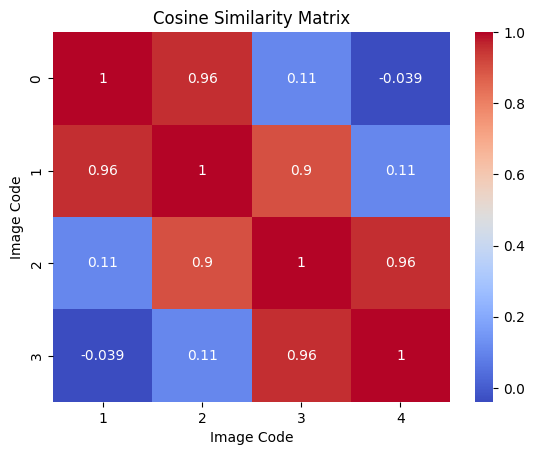

In [30]:
# plot 4 images with cross comparison. axis is image code (1, 2, 3, 4). value is cosine similarity

import seaborn as sns
import pandas as pd

similarity_matrix = pd.DataFrame([[1, alpha1.item(), beta1.item(), beta2.item()], [alpha1.item(), 1, alpha2.item(), beta1.item()], [beta1.item(), alpha2.item(), 1, alpha1.item()], [beta2.item(), beta1.item(), alpha1.item(), 1]], columns=['1', '2', '3', '4'])
sns.heatmap(similarity_matrix, annot=True, cmap='coolwarm')
plt.xlabel('Image Code')
plt.ylabel('Image Code')
plt.title('Cosine Similarity Matrix')

plt.show()

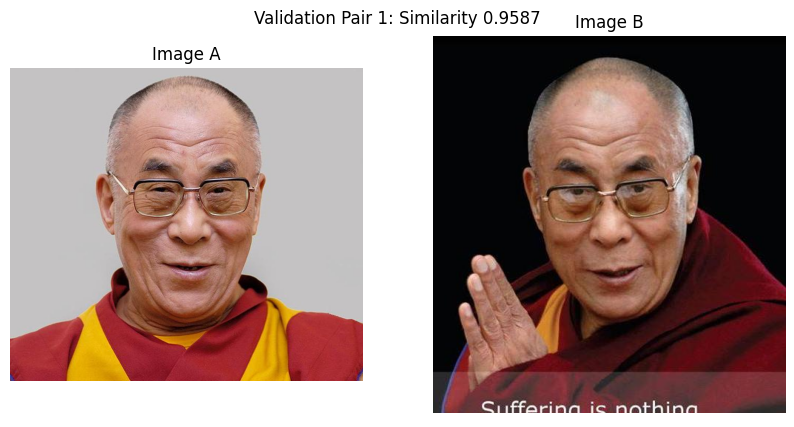

In [11]:
# plot validation pair 1
plt.figure(figsize=(10, 5))
plt.axis('off')
plt.title(f'Validation Pair 1: Similarity {alpha1.item():.4f}')

plt.subplot(1, 2, 1)
plt.imshow(Image.open(vp1_a))
plt.axis('off')
plt.title('Image A')

plt.subplot(1, 2, 2)
plt.imshow(Image.open(vp1_b))
plt.axis('off')
plt.title('Image B')

plt.show()

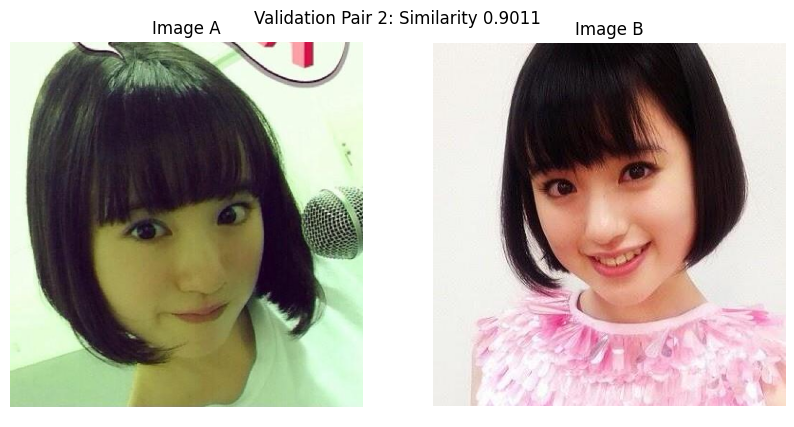

In [25]:
# plot validation pair 2
plt.figure(figsize=(10, 5))
plt.axis('off')
plt.title(f'Validation Pair 2: Similarity {alpha2.item():.4f}')

plt.subplot(1, 2, 1)
plt.imshow(Image.open(vp2_a))
plt.axis('off')
plt.title('Image A')

plt.subplot(1, 2, 2)
plt.imshow(Image.open(vp2_b))
plt.axis('off')
plt.title('Image B')

plt.show()

In [20]:
# confusion matrix

from sklearn.metrics import confusion_matrix
from tqdm import tqdm

# Load validation set
val_dataset = FaceVerificationDataset(
    root_dir='./dataset',
    split='val',
    img_size=224,
    transform=val_transforms,
    normalize=True
)

val_subset = Subset(val_dataset, np.random.choice(len(val_dataset), 1000, replace=False))

val_loader = DataLoader(
    val_subset,
    batch_size=64,
    shuffle=False,
    num_workers=os.cpu_count(),
    pin_memory=torch.cuda.is_available(),
    drop_last=False
)

model.eval()
model = model.cuda()

y_true = []
y_pred = []

with torch.no_grad():
    for img1, img2, labels in tqdm(val_loader):
        img1, img2, labels = img1.cuda(), img2.cuda(), labels.cuda()
        output1 = model(img1)
        output2 = model(img2)
        distance = F.cosine_similarity(output1, output2)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend((distance > 0.5).cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
print(cm)

100%|██████████| 16/16 [00:02<00:00,  7.00it/s]

[[359 158]
 [161 322]]


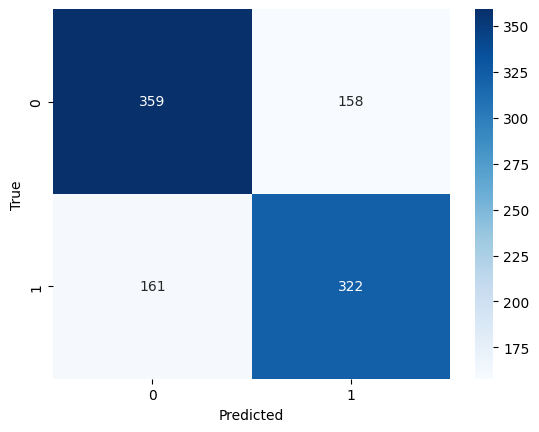

In [22]:
# plot confusion matrix
import seaborn as sns

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [21]:
# auc 

from sklearn.metrics import roc_auc_score

y_score = []
y_true = []

with torch.no_grad():
    for img1, img2, labels in tqdm(val_loader):
        img1, img2, labels = img1.cuda(), img2.cuda(), labels.cuda()
        output1 = model(img1)
        output2 = model(img2)
        distance = F.cosine_similarity(output1, output2)
        y_score.extend(distance.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

auc = roc_auc_score(y_true, y_score)
print(f"AUC: {auc:.4f}")

100%|██████████| 16/16 [00:02<00:00,  7.34it/s]

AUC: 0.7501


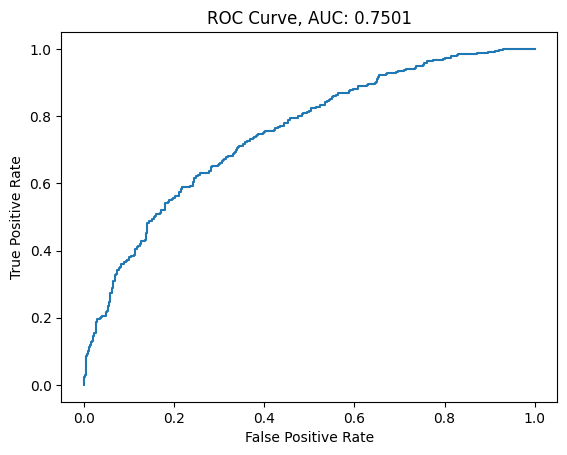

In [23]:
# plot ROC curve
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_true, y_score)

plt.plot(fpr, tpr)
plt.title(f'ROC Curve, AUC: {auc:.4f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()